In [1]:
import torchdata
import torch
from gensim.models import FastText
import pandas as pd
import re
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy

In [2]:
tags = ['<SOS>', '<EOS>', '<PAD>', '<UNK>', '<NAN>', '<NUM>', '<TIME>', '<ENUM>', '<DATE>', '<PHONE>', '<EMAIL>', '<DOTS>', '<SHORT>', '<NAME>']


In [3]:
tags_value = pd.DataFrame({'values': [i / (1+len(tags)) for i in range(1, 1+len(tags))]}, index=tags,)


In [4]:
tags_value.loc['<SOS>', 'values']


0.06666666666666667

In [5]:
def bad_patterns_to_tags_replaser(text: str):
    text = re.sub(r'\d+\:\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\+{,1}\d{1,3}\({,1}[\-\s]{,1}\d{3}\){,1}[\-\s]{,1}\d{3}[\-\s]{,1}\d{2}[\-\s]{,1}\d{2}', ' <PHONE> ', text)
    text = re.sub('\d+/\d+/\d+', ' <DATE> ', text)
    text = re.sub('\d+-\d+-\d+', ' <DATE> ', text)
    text = re.sub('\d+th', ' <ENUM> ', text)
    text = re.sub('\d+rd', ' <ENUM> ', text)
    text = re.sub('\d+st', ' <ENUM> ', text)
    text = re.sub('[\+\-]?\d+.\d+', ' <NUM> ', text)
    text = re.sub('[\+\-]?\d+,\d+', ' <NUM> ', text)
    text = re.sub('\d+', ' <NUM> ', text)
    # text = re.sub(r'\w+\.', '<SHORT>', text[0:-1]) + '.'
    text = re.sub(',', ' , ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub(':', ' : ', text)
    text = re.sub('\?', ' \? ', text)
    text = re.sub('\...', ' <DOTS> ', text)
    text = re.sub('"', ' " ', text)
    text = re.sub("'", " ' ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\.', ' . ', text)
    return text[0:-1]


In [6]:
bad_patterns_to_tags_replaser(
    "I'd wake up at 7:30 or 100:02:20, go... downstairs, and the 123,45%, 123.45%, +123,45%, -123,45%, +123.45%, -123.45%, front phones [+7 999 444 55 66, +7-999-444-55-66, +79994445566, 79994445566, +7(999)-444-55-66, +7(999)-444-5566] door would be open - 600 beers in the kitchen and 20th, 3rd, 1st living room and nobody in the house on 12/12/2012 or 12-12-2012.".lower()
)


"i ' d wake up at <TIME> or <TIME> , go <DOTS> downstairs , and the <NUM> % , <NUM> % , <NUM> % , <NUM> % , <NUM> % , <NUM> % , front phones [ <PHONE> , <PHONE> , <PHONE> , <PHONE> , <PHONE> , <PHONE> ] door would be open - <NUM> beers in the kitchen and <ENUM> , <ENUM> , <ENUM> living room and nobody in the house on <DATE> or <DATE>  ."

In [8]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(sample)
    if x == n:
      break
    x +=1


# Create Dataset

In [ ]:
if os.

In [9]:
with open('../Data/1mcorpus/corpus.en_ru.1m.en', encoding='utf-8') as f:
    eng = f.read().split('\n')
with open('../Data/1mcorpus/corpus.en_ru.1m.ru', encoding='utf-8') as f:
    rus = f.read().split('\n')


In [11]:
pd.DataFrame({'eng': eng, 'rus': rus}).to_csv('../Data/1mcorpus/data.csv', index=False)

In [ ]:
max_len = len(bad_patterns_to_tags_replaser(max(eng + rus, key=len)).split(' '))
max_len


105

# Load Dataset using torchdata

In [ ]:
eng_rus_pairs = torchdata.datapipes.iter.IterableWrapper(['../Data/1mcorpus/data.csv'])

In [ ]:
eng_rus_pairs_pipe = torchdata.datapipes.iter.FileOpener(eng_rus_pairs, mode='r', encoding='utf-8', )

In [ ]:
eng_rus_pairs_pipe_parsed = eng_rus_pairs_pipe.parse_csv(skip_lines=1, delimiter=',')
print_simple_data_pipe(eng_rus_pairs_pipe_parsed, 3)


<class 'torchdata.datapipes.iter.util.plain_text_reader.CSVParserIterDataPipe'>
["This new development in Harry's character may be a disappointment to those readers who enjoyed his old vindictive ways, but it also reinforces the position of pro-Potter people who do not see beneath the surface appearance of the characters and plots.", 'Такое развитие характера Гарри может разочаровать читателей, полюбивших его былую мстительность, но с другой стороны это преображение укрепляет позицию тех, кто не видит глубже сюжета и изображения героев.']
['A nondisclosure clause in the final settlement (the band is back on Elektra) prevents Ulrich, an irrepressible motormouth, from providing any juicy contractual details.', 'Решение суда (группа вернулась под крыло к Elektra Entertainment) предотвратило дальнейшие нападки со стороны неугомонного Ульриха и не позволило ему обнародовать детали нового контракта.']
["When you're 18 or 19 years old, you have that gang mentality in your band.", 'Когда тебе 

# Make Vocab

In [ ]:
def tokenize(text: str) -> list[str]:
  return [t for t in bad_patterns_to_tags_replaser(text.lower()).split()]


In [ ]:
def yield_tokens_eng(data_iter: torchdata.datapipes.iter.IterDataPipe):
  for eng, rus in data_iter:
    yield tokenize(eng)


In [ ]:
def yield_tokens_rus(data_iter: torchdata.datapipes.iter.IterDataPipe):
  for eng, rus in data_iter:
    yield tokenize(rus)


In [ ]:
print_simple_data_pipe(yield_tokens_eng(eng_rus_pairs_pipe_parsed), 3)


<class 'generator'>
['this', 'new', 'development', 'in', 'harry', "'s", 'character', 'may', 'be', 'a', 'disappointment', 'to', 'those', 'readers', 'who', 'enjoyed', 'his', 'old', 'vindictive', 'ways', ',', 'but', 'it', 'also', 'reinforces', 'the', 'position', 'of', 'pro', '-', 'potter', 'people', 'who', 'do', 'not', 'see', 'beneath', 'the', 'surface', 'appearance', 'of', 'the', 'characters', 'and', 'plots', '.']
['a', 'nondisclosure', 'clause', 'in', 'the', 'final', 'settlement', '(the', 'band', 'is', 'back', 'on', 'elektra)', 'prevents', 'ulrich', ',', 'an', 'irrepressible', 'motormouth', ',', 'from', 'providing', 'any', 'juicy', 'contractual', 'details', '.']
['when', 'you', "'re", '<NUM>', 'or', '<NUM>', 'years', 'old', ',', 'you', 'have', 'that', 'gang', 'mentality', 'in', 'your', 'band', '.']
['now', 'you', 'have', 'black', 'sabbath', 'and', 'kiss', 'tribute', 'albums', '.']


In [ ]:
print_simple_data_pipe(yield_tokens_rus(eng_rus_pairs_pipe_parsed), 3)


<class 'generator'>
['такое', 'развитие', 'характера', 'гарри', 'может', 'разочаровать', 'читателей', ',', 'полюбивших', 'его', 'былую', 'мстительность', ',', 'но', 'с', 'другой', 'стороны', 'это', 'преображение', 'укрепляет', 'позицию', 'тех', ',', 'кто', 'не', 'видит', 'глубже', 'сюжета', 'и', 'изображения', 'героев', '.']
['решение', 'суда', '(группа', 'вернулась', 'под', 'крыло', 'к', 'elektra', 'entertainment)', 'предотвратило', 'дальнейшие', 'нападки', 'со', 'стороны', 'неугомонного', 'ульриха', 'и', 'не', 'позволило', 'ему', 'обнародовать', 'детали', 'нового', 'контракта', '.']
['когда', 'тебе', '<NUM>', 'или', '<NUM>', 'лет', ',', 'легко', 'перенимать', 'бандитские', 'повадки', 'и', 'переносить', 'их', 'в', 'группу', '.']
['а', 'сейчас', 'куча', 'триьютов', 'тем', 'же', 'самым', 'black', 'sabbath', 'и', 'kiss', '.']


In [ ]:
if not os.path.isfile('./eng_vocab.pkl'):
    eng_vocab = torchtext.vocab.build_vocab_from_iterator(
        yield_tokens_eng(eng_rus_pairs_pipe_parsed),
        min_freq=2,
        specials=tags,
        special_first=True
    )
    eng_vocab.set_default_index(eng_vocab['<UNK>'])
    with open('./eng_vocab.pkl', 'wb') as f:
        pickle.dump(eng_vocab, f)
else:
    print('already exist')
    with open('./eng_vocab.pkl', 'rb') as f:
        eng_vocab = pickle.load(f)


already exist


In [ ]:
if not os.path.isfile('./rus_vocab.pkl'):
    rus_vocab = torchtext.vocab.build_vocab_from_iterator(
        yield_tokens_rus(eng_rus_pairs_pipe_parsed),
        min_freq=2,
        specials=tags,
        special_first=True
    )
    rus_vocab.set_default_index(rus_vocab['<UNK>'])
    with open('./rus_vocab.pkl', 'wb') as f:
        pickle.dump(rus_vocab, f)
else:
    print('already exist')
    with open('./rus_vocab.pkl', 'rb') as f:
        rus_vocab = pickle.load(f)


already exist


# W2V

In [ ]:
if not os.path.isfile('./w2v_eng.model'):
    w2v_eng = Word2Vec(
        sentences=list(yield_tokens_eng(eng_rus_pairs_pipe_parsed)),
        vector_size=128,
        min_count=1,
        window=5,
        workers=4,
        epochs=10,
        compute_loss=True
    )
    w2v_eng.save('./w2v_eng.model')
else:
    w2v_eng = Word2Vec.load('./w2v_eng.model')
    print('already exist')


In [ ]:
if not os.path.isfile('./w2v_rus.model'):
    w2v_rus = Word2Vec(
        sentences=list(yield_tokens_rus(eng_rus_pairs_pipe_parsed)),
        vector_size=128,
        min_count=1,
        window=5,
        workers=4,
        epochs=10,
        compute_loss=True,
    )

    w2v_eng.save('./w2v_rus.model')
else:
    w2v_rus = Word2Vec.load('./w2v_rus.model')
    print('already exist')


# Preprocessed

In [ ]:
def normalize(pair):
    return (tokenize(pair[0]), tokenize(pair[1]))


In [ ]:
def vocab_transform(vocab: torchtext.vocab.Vocab) -> torchtext.transforms.Sequential:
    text_tranform = torchtext.transforms.Sequential(
        torchtext.transforms.AddToken('<SOS>', begin=True),
        torchtext.transforms.AddToken('<EOS>', begin=False)
    )
    return text_tranform


In [ ]:
def apply_vocab_transform(pair):
    return (
        vocab_transform(eng_vocab)(tokenize(pair[0])),
        vocab_transform(rus_vocab)(tokenize(pair[1]))
    )


In [ ]:
def vectorize_frase(text, max_lenght, vectorizer: Word2Vec):
    matrix = []
    for i in range(max_lenght):
        if i < len(text):
            if text[i] in tags:
                matrix.append((np.ones(vectorizer.vector_size) * tags_value.loc[text[i], 'values']).tolist())
            else:
                matrix.append((vectorizer.wv[text[i]]).tolist())
        else:
            matrix.append((np.ones(vectorizer.vector_size) * tags_value.loc['<PAD>', 'values']).tolist())
    return torch.tensor(matrix).float()


In [ ]:
def vectorize_frase_fixed(pair):
    # print(pair[0])
    k1 = vectorize_frase(pair[0], max_len + 2, w2v_eng)
    # print(k1.shape)
    k2 = vectorize_frase(pair[1], max_len + 2, w2v_rus)
    # print(k2.shape)
    return (k1, k2)


In [ ]:
eng_rus_pairs_pipe_normalized = eng_rus_pairs_pipe_parsed.map(normalize)
print_simple_data_pipe(eng_rus_pairs_pipe_normalized, 3)


<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(['this', 'new', 'development', 'in', 'harry', "'s", 'character', 'may', 'be', 'a', 'disappointment', 'to', 'those', 'readers', 'who', 'enjoyed', 'his', 'old', 'vindictive', 'ways', ',', 'but', 'it', 'also', 'reinforces', 'the', 'position', 'of', 'pro', '-', 'potter', 'people', 'who', 'do', 'not', 'see', 'beneath', 'the', 'surface', 'appearance', 'of', 'the', 'characters', 'and', 'plots', '.'], ['такое', 'развитие', 'характера', 'гарри', 'может', 'разочаровать', 'читателей', ',', 'полюбивших', 'его', 'былую', 'мстительность', ',', 'но', 'с', 'другой', 'стороны', 'это', 'преображение', 'укрепляет', 'позицию', 'тех', ',', 'кто', 'не', 'видит', 'глубже', 'сюжета', 'и', 'изображения', 'героев', '.'])
(['a', 'nondisclosure', 'clause', 'in', 'the', 'final', 'settlement', '(the', 'band', 'is', 'back', 'on', 'elektra)', 'prevents', 'ulrich', ',', 'an', 'irrepressible', 'motormouth', ',', 'from', 'providing', 'any', 'juicy', 

In [ ]:
eng_rus_pairs_pipe_vectorized = eng_rus_pairs_pipe_normalized.map(vectorize_frase_fixed)
print_simple_data_pipe(eng_rus_pairs_pipe_vectorized, 1)


<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(tensor([[ 0.6977, -0.2862,  0.7218,  ..., -5.3197,  1.4442, -2.1224],
        [-0.1535,  1.2523, -0.9845,  ..., -0.2049, -1.2072, -1.8908],
        [-0.2193,  1.1159, -3.6051,  ...,  0.3099,  2.1877, -3.9869],
        ...,
        [ 0.2000,  0.2000,  0.2000,  ...,  0.2000,  0.2000,  0.2000],
        [ 0.2000,  0.2000,  0.2000,  ...,  0.2000,  0.2000,  0.2000],
        [ 0.2000,  0.2000,  0.2000,  ...,  0.2000,  0.2000,  0.2000]]), tensor([[-0.6569,  0.4356,  1.5196,  ...,  4.0749, -3.1023,  2.7302],
        [ 2.3981,  0.0307,  1.3253,  ..., -2.4002, -0.5166, -0.2387],
        [-2.8937,  0.0412, -2.9933,  ..., -2.2109, -0.0264, -1.9518],
        ...,
        [ 0.2000,  0.2000,  0.2000,  ...,  0.2000,  0.2000,  0.2000],
        [ 0.2000,  0.2000,  0.2000,  ...,  0.2000,  0.2000,  0.2000],
        [ 0.2000,  0.2000,  0.2000,  ...,  0.2000,  0.2000,  0.2000]]))
(tensor([[-0.1196,  0.1542,  0.5710,  ..., -2.1419,  2.4303

In [ ]:
def create_position_coording_matrix(height, length):
    matrix = (torch.ones(length, height) * torch.arange(0., length).view(-1, 1).float()).T
    for i in range(height):
        matrix[i][torch.arange(0., length) % 2 == 0] = np.sin(i / (10000 ** (2*matrix[i][torch.arange(0., length) % 2 == 0]/length)))
        matrix[i][torch.arange(0., length) % 2 != 0] = np.cos(i / (10000 ** (2*matrix[i][torch.arange(0., length) % 2 != 0]/length)))
    return matrix
        

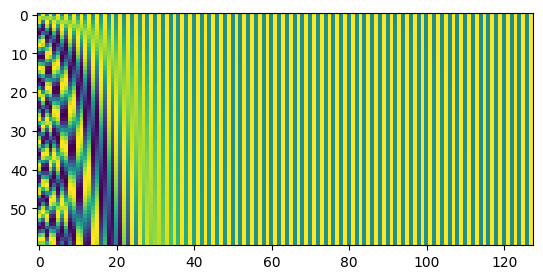

In [ ]:
plt.imshow(create_position_coording_matrix(60, 128))


In [ ]:
def position_codding(pair):
    return (pair[0] + create_position_coording_matrix(pair[0].shape[0], pair[0].shape[1]), pair[1] + create_position_coording_matrix(pair[1].shape[0], pair[1].shape[1]))


In [ ]:
eng_rus_pairs_pipe_coorded_coded = eng_rus_pairs_pipe_vectorized.map(position_codding)
print_simple_data_pipe(eng_rus_pairs_pipe_coorded_coded, 1)


<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(tensor([[ 6.9767e-01,  7.1384e-01,  7.2179e-01,  ..., -4.3197e+00,
          1.4442e+00, -1.1224e+00],
        [ 6.8800e-01,  1.9002e+00, -3.0298e-01,  ...,  7.9511e-01,
         -1.2072e+00, -8.9076e-01],
        [ 6.8997e-01,  9.5548e-01, -2.6076e+00,  ...,  1.3099e+00,
          2.1877e+00, -2.9869e+00],
        ...,
        [-1.2162e-01, -3.0113e-01,  7.2338e-01,  ...,  1.2000e+00,
          2.0000e-01,  1.2000e+00],
        [-7.7054e-01, -7.8386e-01,  2.2371e-03,  ...,  1.2000e+00,
          2.0000e-01,  1.2000e+00],
        [-5.2714e-01, -5.7376e-01, -6.1282e-01,  ...,  1.2000e+00,
          2.0000e-01,  1.2000e+00]]), tensor([[-6.5686e-01,  1.4356e+00,  1.5196e+00,  ...,  5.0749e+00,
         -3.1023e+00,  3.7302e+00],
        [ 3.2396e+00,  6.7857e-01,  2.0068e+00,  ..., -1.4002e+00,
         -5.1656e-01,  7.6131e-01],
        [-1.9844e+00, -1.1924e-01, -1.9958e+00,  ..., -1.2109e+00,
         -2.6379e-02, -

In [ ]:
eng_rus_pairs_pipe_batch = eng_rus_pairs_pipe_coorded_coded.bucketbatch(
    batch_size=256,
    use_in_batch_shuffle=False
)


# Model Build

In [ ]:
class FraseMatrixProcessorLayer(torch.nn.Module):
    def __init__(
            self, 
            input_dimention, 
            output_dimention,
            num_of_samples,
            alpha=5,
        ):
        super().__init__()
        self.input_dimention = input_dimention
        self.output_dimention = output_dimention
        self.num_of_samples = num_of_samples
        self.num_layers_of_main_layer = int(num_of_samples / (alpha * (self.input_dimention + self.output_dimention)) + 1)
        self.main_layer = torch.nn.GRU(
            input_size=input_dimention, 
            hidden_size=output_dimention, 
            num_layers=self.num_layers_of_main_layer
        )
        self.h = torch.zeros(
            self.num_layers_of_main_layer, 
            self.output_dimention
        ).requires_grad_().float()

    def forward(self, matrix: torch.tensor):
        resulted_matrix = torch.zeros(self.num_of_samples, self.output_dimention)
        for i in range(matrix.shape[0]):
            resulted_matrix, self.h = self.main_layer(matrix, self.h)
        return resulted_matrix

In [ ]:
for i, j in eng_rus_pairs_pipe_coorded_coded:
    test = i
    break


In [ ]:
test.shape


torch.Size([107, 128])

In [ ]:
t = FraseMatrixProcessorLayer(
    input_dimention=test.shape[1],
    output_dimention=20,
    num_of_samples=test.shape[0],
)


In [ ]:
t(test)

tensor([[ 0.9403, -0.3526,  0.2531,  ..., -0.1046, -0.4123,  0.7941],
        [-0.9553, -0.5446,  0.9518,  ...,  0.3328, -0.6510,  0.7575],
        [ 0.8228, -0.4789,  0.9872,  ...,  0.8938, -0.6730, -0.8143],
        ...,
        [ 0.5403,  0.8199,  0.4174,  ...,  0.9926,  0.0215, -0.6201],
        [ 0.5655,  0.8360,  0.3539,  ...,  0.9927, -0.0732, -0.6462],
        [ 0.5897,  0.8540,  0.3696,  ...,  0.9918, -0.1514, -0.7572]],
       grad_fn=<SqueezeBackward1>)

In [ ]:
torch.cuda.is_available()


False

In [ ]:
class MyTransformer(torch.nn.Module):
    def __init__(self, input_dimention, output_dimention):
        super().__init__()

    def frase_matrix_first_processing(self, matrix):
        

    def forward(self, matrix: torch.tensor):
        Q = matrix
        K = matrix
        V = matrix
        embedded = self.embedding(text)
        output, hidden = self.gru(embedded)
        output, hidden = self.gru2(output)
        output, hidden = self.gru3(output)
        return self.fc(hidden.squeeze(0))
